# Importing the Libraries


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from spacy import displacy
from spacy import tokenizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import gensim 
import gensim.corpora as corpora 
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel,TfidfModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score,classification_report

In [3]:
# set plot options

plt.rcParams["figure.figsize"]=(12,8)
default_plot_colour="#00bfbf"

## Loading the Data

In [4]:
data=pd.read_csv("fake_news_data.csv")

In [5]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB


Text(0.5, 1.0, 'Count of Article Classification')

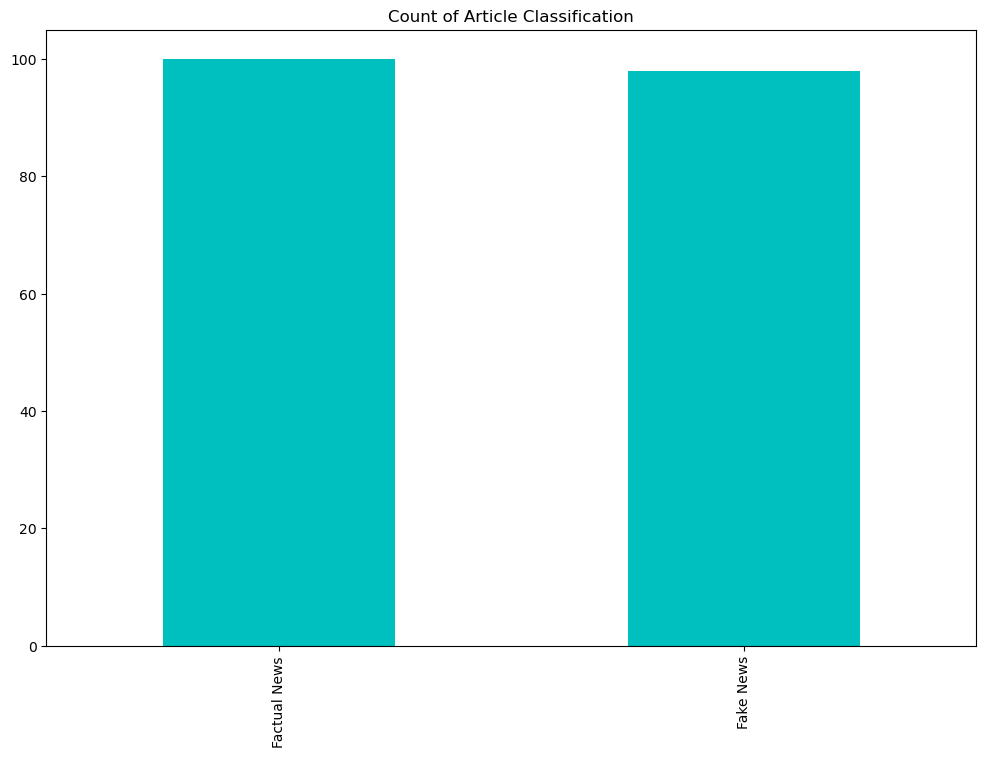

In [7]:
data["fake_or_factual"].value_counts().plot(kind="bar",color=default_plot_colour)
plt.title("Count of Article Classification")

## Pos Tagging

In [8]:
nlp=spacy.load("en_core_web_sm")

In [9]:
fake_news=data[data["fake_or_factual"]=="Fake News"]


In [13]:
fake_news

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
5,Maxine Waters Makes Teens Chant ‘Impeach 45′ a...,Shame on Teen Vogue! Maxine Waters was a guest...,"Dec 10, 2017",Fake News
6,Jay Carney Let It Slip That He Knows Who Obam...,Former White House Press Secretary in the Obam...,"February 10, 2016",Fake News
...,...,...,...,...
191,Terrorist Jon Ritzheimer Uses Sobbing Daughte...,"Jon Ritzheimer, infamous hater of Muslims and ...","January 26, 2016",Fake News
193,AND SO IT BEGINS…INSPIRED BY GAY MARRIAGE RULI...,"Well, that didn t take long. Look for the firs...","Jul 2, 2015",Fake News
194,‘Stand Your Ground’: FL Man Shoots At Teens P...,Florida s toxic and dangerous stand your grou...,"July 17, 2016",Fake News
195,The Los Angeles Times Endorses Hillary Clinto...,As Politico reports an almost neck-and-neck ra...,"May 30, 2016",Fake News


In [10]:
fact_news=data[data["fake_or_factual"]== "Factual News"]

In [14]:
fact_news

,title,text,date,fake_or_factual
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News
7,"Trump threat fires up U.S. climate activists, ...",(Reuters) - Seattle financial worker Harrison ...,"November 11, 2016",Factual News
9,China labels Trump call 'petty action' by Taiw...,BEIJING (Reuters) - U.S. President-elect Donal...,"December 3, 2016",Factual News
11,Kerry says can't comment on content of Clinton...,QUEBEC CITY (Reuters) - U.S. Secretary of Stat...,"January 29, 2016",Factual News
...,...,...,...,...
184,White House not aware of other nations plannin...,WASHINGTON (Reuters) - The White House said on...,"December 7, 2017",Factual News
185,Four killed as militants attack airport securi...,SRINAGAR (Reuters) - Indian police on Tuesday ...,"October 3, 2017",Factual News
188,Chinese aircraft drill again in Western Pacific,BEIJING (Reuters) - Chinese military aircraft ...,"December 21, 2017",Factual News
192,"France close to Qatar military, transport cont...",PARIS (Reuters) - France is close to finalizin...,"December 4, 2017",Factual News


In [19]:
fake_spacydocs=list(nlp.pipe(fake_news["text"]))
fact_spacydocs=list(nlp.pipe(fact_news["text"]))


In [48]:
def extract_token_tags(doc:spacy.tokens.doc.Doc):
    return [(i.text,i.ent_type_,i.pos_) for i in doc]

In [49]:
fake_tagsdf=[]
columns=["token","ner_tag","pos_tag"]

In [50]:
for ix , doc in enumerate(fake_spacydocs):
    tags=extract_token_tags(doc)
    tags=pd.DataFrame(tags)
    tags.columns=columns
    fake_tagsdf.append(tags)

In [51]:
fake_tagsdf=pd.concat(fake_tagsdf)

In [52]:
fake_tagsdf

,token,ner_tag,pos_tag
0,There,,PRON
1,are,,VERB
2,two,CARDINAL,NUM
3,small,,ADJ
4,problems,,NOUN
...,...,...,...
743,.,,PUNCT
744,Via,,NOUN
745,:,,PUNCT
746,Campus,,PROPN


In [53]:
fact_tagsdf=[]

for ix , doc in enumerate(fact_spacydocs):
    tags=extract_token_tags(doc)
    tags=pd.DataFrame(tags)
    tags.columns=columns
    fact_tagsdf.append(tags)

In [54]:
fact_tagsdf=pd.concat(fact_tagsdf)

In [55]:
pos_counts_fake=fake_tagsdf.groupby(["token","pos_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)
pos_counts_fake.head(10)

,token,pos_tag,counts
28,",",PUNCT,1908
7446,the,DET,1834
39,.,PUNCT,1531
5759,of,ADP,922
2661,and,CCONJ,875
2446,a,DET,804
0,,SPACE,795
7523,to,PART,767
4915,in,ADP,667
5094,is,AUX,419


In [56]:
pos_counts_fact=fact_tagsdf.groupby(["token","pos_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)
pos_counts_fact.head(10)

,token,pos_tag,counts
6169,the,DET,1903
15,",",PUNCT,1698
22,.,PUNCT,1381
4733,of,ADP,884
1905,a,DET,789
2100,and,CCONJ,757
4015,in,ADP,672
6230,to,PART,660
4761,on,ADP,482
5586,said,VERB,452


In [57]:
pos_counts_fake.groupby("pos_tag")["token"].count().sort_values(ascending=False)

pos_tag
NOUN     2597
VERB     1814
PROPN    1657
ADJ       876
ADV       412
NUM       221
PRON       99
ADP        88
AUX        58
SCONJ      54
DET        42
INTJ       27
PUNCT      27
X          19
CCONJ      19
PART       10
SYM         6
SPACE       3
Name: token, dtype: int64

In [58]:
pos_counts_fact.groupby("pos_tag")["token"].count().sort_values(ascending=False)

pos_tag
NOUN     2182
VERB     1535
PROPN    1387
ADJ       753
ADV       271
NUM       203
PRON       81
ADP        70
AUX        44
SCONJ      39
DET        35
PUNCT      19
X          12
SPACE      11
CCONJ       9
INTJ        8
PART        8
SYM         5
Name: token, dtype: int64

In [59]:
pos_counts_fake[pos_counts_fake["pos_tag"]=="NOUN"]

,token,pos_tag,counts
5969,people,NOUN,77
7959,women,NOUN,55
6204,president,NOUN,53
7511,time,NOUN,52
8011,year,NOUN,44
...,...,...,...
3783,diagnosis,NOUN,1
3780,devil,NOUN,1
3779,devices,NOUN,1
3777,developments,NOUN,1


In [60]:
pos_counts_fact[pos_counts_fact["pos_tag"]=="NOUN"]

,token,pos_tag,counts
3748,government,NOUN,71
6639,year,NOUN,64
5927,state,NOUN,58
2373,bill,NOUN,55
1982,administration,NOUN,51
...,...,...,...
4202,journalist,NOUN,1
4205,journey,NOUN,1
4153,investigator,NOUN,1
1768,U.S.-Mexico,NOUN,1


## Named Entities

In [61]:
top_entities_fake=fake_tagsdf[fake_tagsdf["ner_tag"]!= ""].groupby(["token","ner_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [62]:
top_entities_fact=fact_tagsdf[fact_tagsdf["ner_tag"]!= ""].groupby(["token","ner_tag"]).size().reset_index(name="counts").sort_values(by="counts",ascending=False)

In [63]:
ner_palette={
    
    "ORG":sns.color_palette("Set2").as_hex()[0],
    "GPE":sns.color_palette("Set2").as_hex()[1],
    "NORP":sns.color_palette("Set2").as_hex()[2],
    "PERSON":sns.color_palette("Set2").as_hex()[3],
    "DATE":sns.color_palette("Set2").as_hex()[4],
    "CARDINAL":sns.color_palette("Set2").as_hex()[5],
    "PERCENT":sns.color_palette("Set2").as_hex()[6]
}

[Text(0.5, 1.0, 'MOST COMMON NAMED ENTITIES IN FAKE NEWS')]

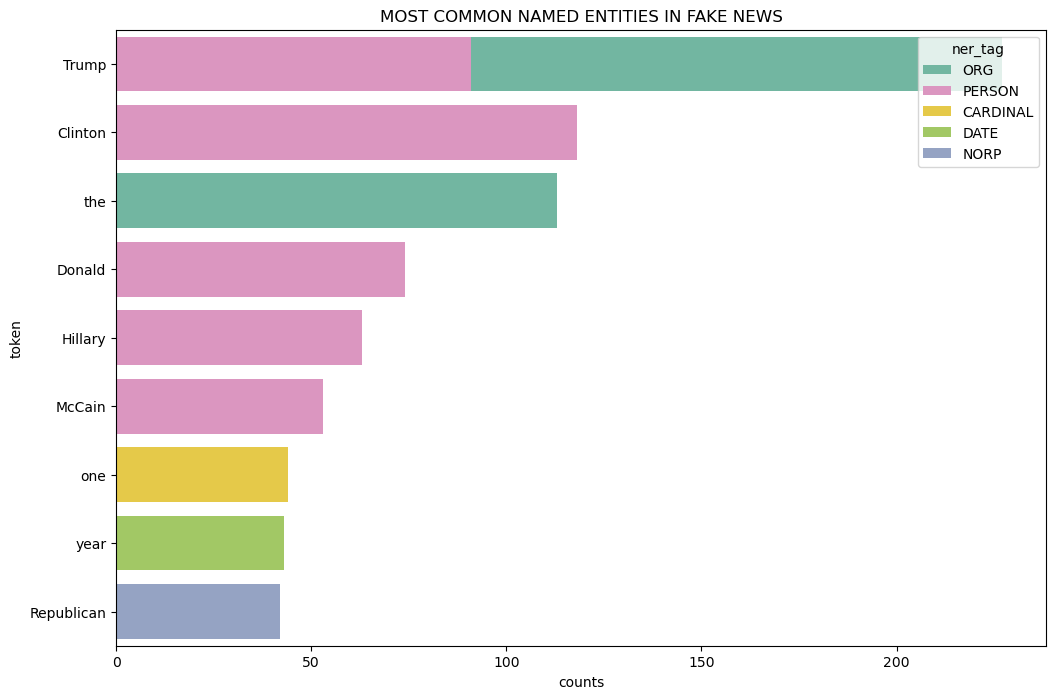

In [64]:
sns.barplot(x="counts",y="token",hue="ner_tag",palette=ner_palette,data=top_entities_fake[:10],
           orient="h",dodge=False).set(title="MOST COMMON NAMED ENTITIES IN FAKE NEWS")

[Text(0.5, 1.0, 'MOST COMMON NAMED ENTITIES IN Fact NEWS')]

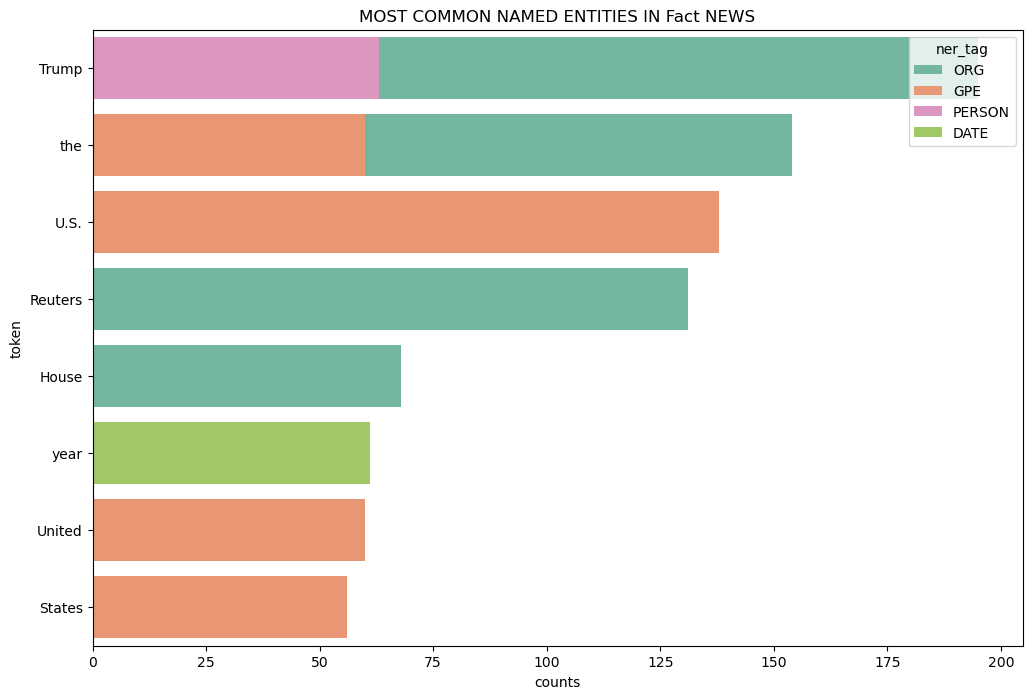

In [66]:
sns.barplot(x="counts",y="token",hue="ner_tag",palette=ner_palette,data=top_entities_fact[:10],
           orient="h",dodge=False).set(title="MOST COMMON NAMED ENTITIES IN Fact NEWS")

#  The Text Preprocessing

In [67]:
data.head()

,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


In [68]:
data["text_clean"]=data.apply(lambda x:re.sub(r"^[^-]*-\s","",x["text"]),axis=1)

In [69]:
data["text_clean"]=data["text_clean"].str.lower()

In [70]:
data["text_clean"]=data.apply(lambda x:re.sub(r"([^\w\s])","",x["text_clean"]),axis=1)

In [71]:
en_stopwords=stopwords.words("english")

In [72]:
print(en_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [74]:
data["text_clean"]=data["text_clean"].apply(lambda x: " ".join([word for word in x.split() if word not in (en_stopwords)]))

In [76]:
data["text_clean"]=data.apply(lambda x:word_tokenize(x["text_clean"]),axis=1)

In [77]:
lemmatizer=WordNetLemmatizer()

In [78]:
data["text_clean"]=data["text_clean"].apply(lambda tokens : [lemmatizer.lemmatize(token) for token in tokens])

In [79]:
data.head()

,title,text,date,fake_or_factual,text_clean
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m..."
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,..."
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u..."
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon..."
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,..."


In [80]:
tokens_clean=sum(data["text_clean"],[])

In [81]:
unigrams=(pd.Series(nltk.ngrams(tokens_clean,1)).value_counts())
unigrams[:10]

(trump,)         580
(said,)          580
(u,)             277
(state,)         275
(president,)     259
(would,)         226
(one,)           160
(clinton,)       141
(year,)          139
(republican,)    137
dtype: int64

[Text(0.5, 1.0, 'Most Common Unigrams After PreProcessing')]

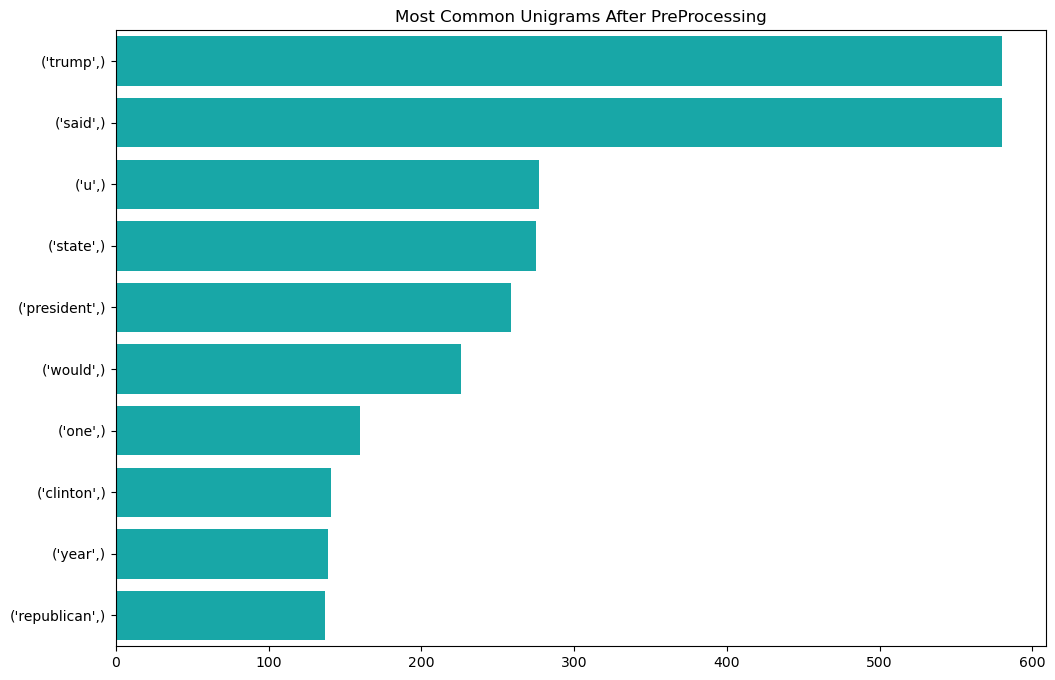

In [82]:
sns.barplot(x=unigrams[:10],y=unigrams.index[:10],
           orient="h",
           palette=[default_plot_colour]
           ).set(title="Most Common Unigrams After PreProcessing")

In [83]:
bigrams=(pd.Series(nltk.ngrams(tokens_clean,2)).value_counts())
bigrams[:10]

(donald, trump)            113
(united, state)             84
(white, house)              74
(president, donald)         47
(hillary, clinton)          39
(new, york)                 33
(supreme, court)            30
(image, via)                29
(official, said)            26
(trump, administration)     26
dtype: int64

## Sentiment Analysis 

In [84]:
vader_sentiment=SentimentIntensityAnalyzer()

In [85]:
data["vader_sentiment_score"]=data["text"].apply(lambda x: vader_sentiment.polarity_scores(x)["compound"])

In [86]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590


In [87]:
bins=[-1,-0.1,0.1,1]
names=["nagative","neutral","positive"]
data["vader_sentiment_label"]=pd.cut(data["vader_sentiment_score"],bins,labels=names)

In [88]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,nagative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,nagative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,nagative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


<AxesSubplot:>

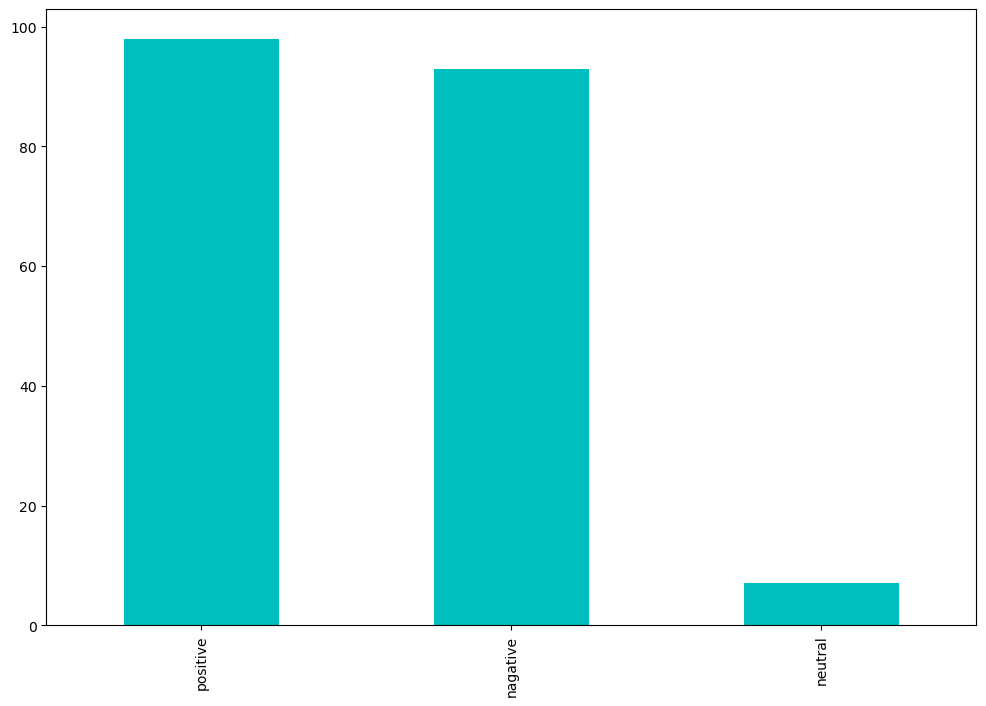

In [90]:
data["vader_sentiment_label"].value_counts().plot.bar(color=default_plot_colour)

[Text(0.5, 1.0, 'Sentiment by News Type')]

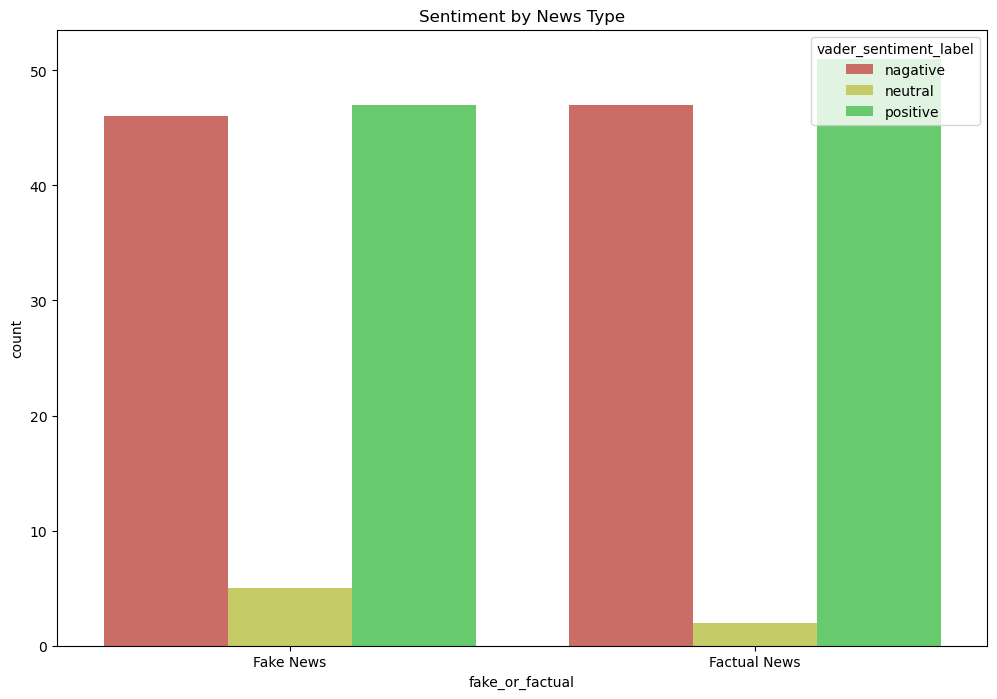

In [91]:
sns.countplot(x="fake_or_factual",hue="vader_sentiment_label",
             palette=sns.color_palette("hls"),
             data=data).set(title="Sentiment by News Type")

## Topics observations

### LDA

In [92]:
fake_news_text= data[data["fake_or_factual"]== "Fake News"]["text_clean"].reset_index(drop=True)

In [93]:
dictionary_fake=corpora.Dictionary(fake_news_text)

In [94]:
dictionary_fake

In [95]:
doc_term_fake=[dictionary_fake.doc2bow(text) for text in fake_news_text]

In [96]:
coherence_values=[]
model_list=[]

min_topics=2
max_topics=11

for num_topics_i in range(min_topics,max_topics+1):
    model=gensim.models.LdaModel(doc_term_fake,num_topics=num_topics_i,id2word=dictionary_fake)
    model_list.append(model)
    coherence_model=CoherenceModel(model=model,texts=fake_news_text,dictionary=dictionary_fake,coherence="c_v")
    coherence_values.append(coherence_model.get_coherence())

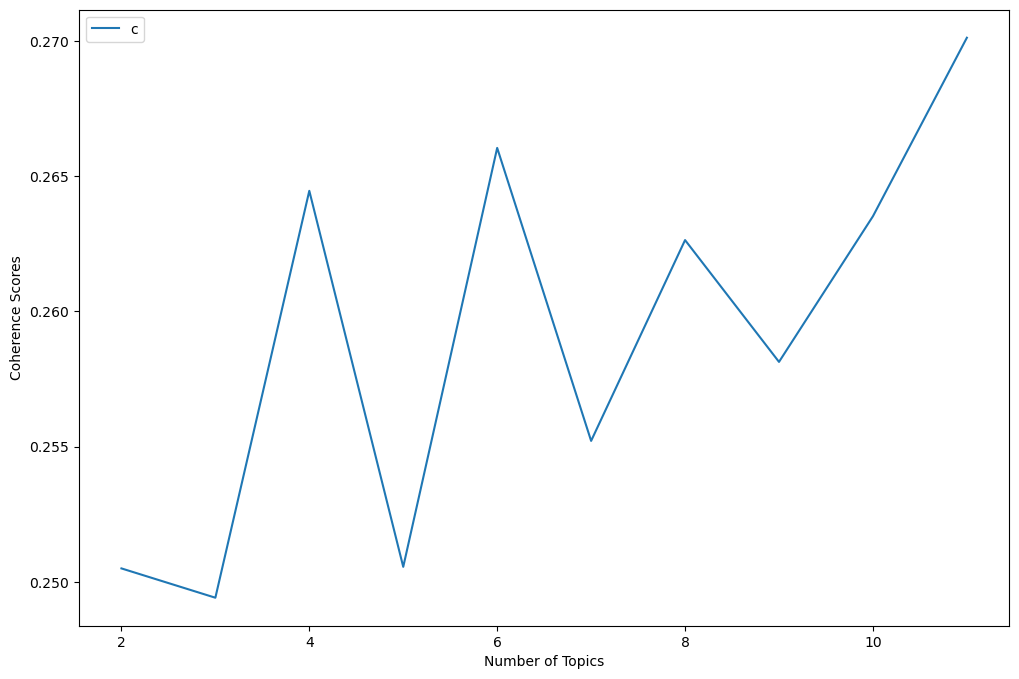

In [98]:
plt.plot(range(min_topics,max_topics+1),coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Scores")
plt.legend(("coherence_values"),loc="best")
plt.show()

In [99]:
nums_topics_lda=6
lda_model=gensim.models.LdaModel(corpus=doc_term_fake,num_topics=nums_topics_lda,id2word=dictionary_fake)

In [100]:
lda_model.print_topics(num_topics=nums_topics_lda,num_words=10)

[(0,
  '0.013*"trump" + 0.005*"said" + 0.004*"state" + 0.004*"clinton" + 0.004*"republican" + 0.004*"time" + 0.003*"would" + 0.003*"people" + 0.003*"hillary" + 0.003*"president"'),
 (1,
  '0.008*"trump" + 0.005*"clinton" + 0.004*"president" + 0.003*"one" + 0.003*"would" + 0.003*"state" + 0.003*"woman" + 0.003*"year" + 0.003*"u" + 0.002*"even"'),
 (2,
  '0.010*"trump" + 0.007*"clinton" + 0.005*"state" + 0.005*"one" + 0.004*"president" + 0.004*"would" + 0.004*"said" + 0.004*"republican" + 0.003*"people" + 0.003*"donald"'),
 (3,
  '0.012*"trump" + 0.006*"said" + 0.006*"president" + 0.005*"u" + 0.004*"obama" + 0.004*"state" + 0.004*"woman" + 0.004*"one" + 0.003*"time" + 0.003*"people"'),
 (4,
  '0.014*"trump" + 0.006*"would" + 0.005*"said" + 0.004*"one" + 0.004*"republican" + 0.004*"state" + 0.004*"president" + 0.003*"american" + 0.003*"donald" + 0.003*"time"'),
 (5,
  '0.007*"trump" + 0.004*"state" + 0.004*"u" + 0.004*"president" + 0.003*"said" + 0.003*"clinton" + 0.003*"time" + 0.003*"of

## TFIDF 

In [105]:
def tfidf_corpus(doc_term_matrix):
    tfidf=TfidfModel(corpus=doc_term_matrix,normalize=True)
    corpus_tfidf= tfidf[doc_term_matrix]
    return corpus_tfidf

In [106]:
def get_coherence_scores(corpus,dictionary,text,min_topics,max_topics):
    coherence_values=[]
    model_list=[]
    for num_topics_i in range(min_topics,max_topics+1):
        model=LsiModel(corpus,num_topics= num_topics_i,id2word=dictionary )
        model_list.append(model)
        coherence_model=CoherenceModel(model=model,texts=text,dictionary=dictionary,coherence="c_v")
        coherence_values.append(coherence_model.get_coherence())
    plt.plot(range(min_topics,max_topics+1),coherence_values)
    plt.xlabel("number of topics")
    plt.ylabel("coherence score ")
    plt.legend(("coherence_values"),loc="best")
    plt.show()

In [107]:
corpus_tfidf_fake=tfidf_corpus(doc_term_fake)

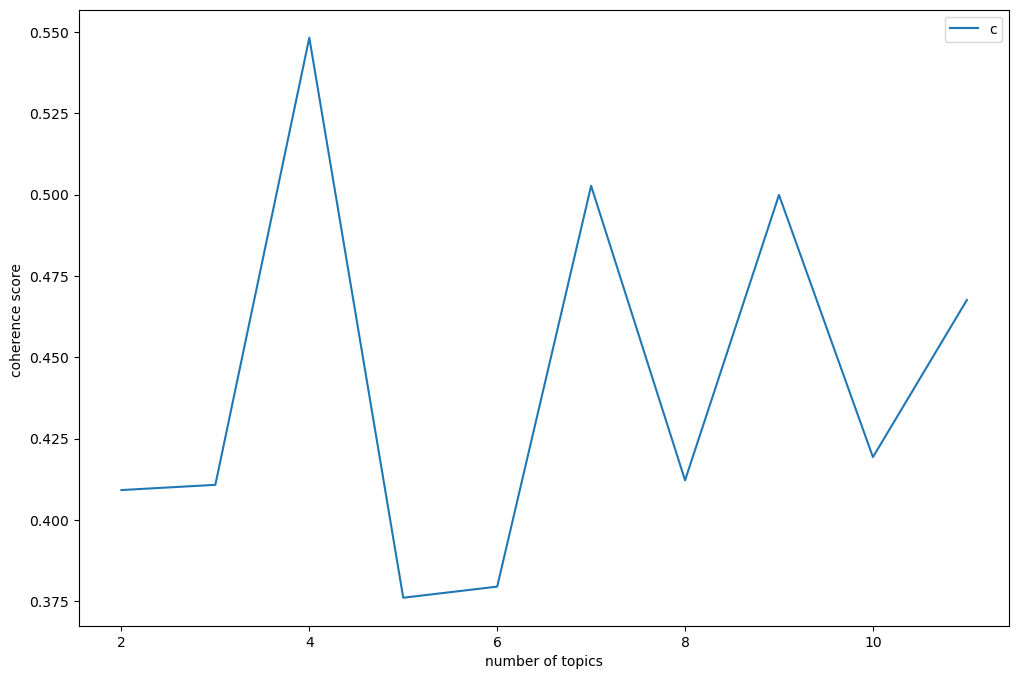

In [108]:
get_coherence_scores(corpus_tfidf_fake,dictionary_fake,fake_news_text,min_topics=2,max_topics=11)

In [111]:
lsa_model=LsiModel(corpus_tfidf_fake,id2word=dictionary_fake,num_topics=7)

In [112]:
lsa_model.print_topics()

[(0,
  '0.190*"trump" + 0.136*"clinton" + 0.095*"hillary" + 0.094*"obama" + 0.089*"president" + 0.087*"woman" + 0.078*"republican" + 0.077*"party" + 0.077*"flynn" + 0.074*"candidate"'),
 (1,
  '-0.325*"boiler" + -0.284*"acr" + -0.244*"room" + -0.240*"pm" + -0.186*"broadcast" + -0.180*"radio" + -0.142*"animal" + -0.142*"tune" + -0.134*"jay" + -0.132*"episode"'),
 (2,
  '-0.622*"flynn" + -0.182*"immunity" + -0.122*"nana" + -0.116*"mr" + -0.110*"30" + -0.108*"march" + -0.102*"russian" + -0.100*"source" + 0.095*"school" + -0.092*"adviser"'),
 (3,
  '0.217*"clinton" + -0.185*"school" + -0.175*"student" + 0.141*"hillary" + -0.122*"flynn" + -0.121*"county" + 0.110*"sander" + 0.097*"debate" + 0.097*"woman" + 0.091*"nominee"'),
 (4,
  '0.200*"email" + -0.194*"trump" + 0.168*"dnc" + -0.143*"flynn" + 0.126*"clinton" + -0.112*"cruz" + 0.111*"department" + 0.110*"rich" + 0.102*"wikileaks" + 0.099*"sander"'),
 (5,
  '-0.276*"student" + -0.162*"conference" + -0.160*"school" + -0.138*"trump" + 0.124*"

## Classification model

In [113]:
data.head()

,title,text,date,fake_or_factual,text_clean,vader_sentiment_score,vader_sentiment_label
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News,"[two, small, problem, analogy, susan, jesus, m...",-0.3660,nagative
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News,"[buried, trump, bonkers, interview, new, york,...",-0.8197,nagative
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News,"[woman, make, 50, percent, country, grossly, u...",0.9779,positive
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News,"[u, defense, secretary, jim, mattis, said, mon...",-0.3400,nagative
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News,"[northern, ireland, political, party, rapidly,...",0.8590,positive


In [114]:
X=[",".join(map(str,l)) for l in data["text_clean"]]

In [116]:
Y=data["fake_or_factual"]

In [117]:
countvec=CountVectorizer()

In [124]:
countvec_fit=countvec.fit_transform(X)

In [125]:
bag_of_words=pd.DataFrame(countvec_fit.toarray(),columns=countvec.get_feature_names_out())

In [136]:
X_train,X_test,Y_train,Y_test=train_test_split(bag_of_words,Y,test_size=0.3,random_state=365)

### Logistic Regression

In [137]:
lr=LogisticRegression(random_state=85).fit(X_train,Y_train)

In [138]:
y_pred_lr=lr.predict(X_test)

In [139]:
accuracy_score(y_pred_lr,Y_test)

0.8666666666666667

In [140]:
print(classification_report(Y_test,y_pred_lr))

              precision    recall  f1-score   support

Factual News       0.81      0.93      0.87        28
   Fake News       0.93      0.81      0.87        32

    accuracy                           0.87        60
   macro avg       0.87      0.87      0.87        60
weighted avg       0.87      0.87      0.87        60



In [146]:
svm=SGDClassifier(random_state=365).fit(X_train,Y_train)


In [147]:
y_pred_svm=svm.predict(X_test)

In [148]:
accuracy_score(y_pred_svm,Y_test)

0.9

In [149]:
print(classification_report(Y_test,y_pred_svm))

              precision    recall  f1-score   support

Factual News       0.92      0.86      0.89        28
   Fake News       0.88      0.94      0.91        32

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60

